In [1]:
from pandas import read_csv, DataFrame
from datetime import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

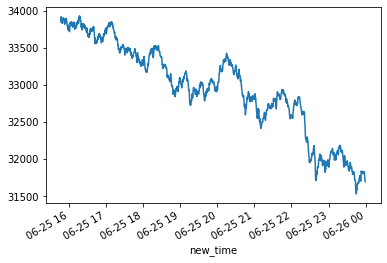

In [2]:
series = read_csv('./Data/Processed_BT_PriceDB.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
series.plot()
pyplot.show()

In [3]:
X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

## WARNING: this code took me 15 min to run!

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) # add the actual value back in the model

/Users/mz195/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test RMSE: 71.706


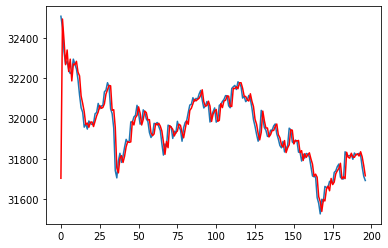

In [25]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()